<a href="https://colab.research.google.com/github/claude9493/DSAA5002/blob/main/notebook/BetaRec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/claude9493/dsaa5002.git
!mv ./dsaa5002/dataset/ ./
!mv ./dsaa5002/utils/ ./

!pip install geomloss

Cloning into 'dsaa5002'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 104 (delta 30), reused 9 (delta 3), pack-reused 0
Receiving objects: 100% (104/104), 9.72 MiB | 12.92 MiB/s, done.
Resolving deltas: 100% (30/30), done.


In [6]:
%%time

from utils.utils import create_dataset, Trainer
# from layer.layer import Embedding, FeaturesEmbedding, EmbeddingsInteraction, MultiLayerPerceptron

import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ConstantLR

from torch.utils.data import TensorDataset, DataLoader

from geomloss import SamplesLoss

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Training on [{}].'.format(device))

Training on [cuda:0].
CPU times: user 591 µs, sys: 626 µs, total: 1.22 ms
Wall time: 3.53 ms


In [3]:
%%time
SAMPLE_NUM = 10000
task = 'regression'  # 'classification'
dataset = create_dataset('movielens', sample_num=SAMPLE_NUM, task=task, device=device)
field_dims, (train_X, train_y), (valid_X, valid_y), (test_X, test_y) = dataset.train_valid_test_split()

CPU times: user 1.86 s, sys: 1.06 s, total: 2.92 s
Wall time: 16.5 s


In [4]:
class Beta_Loss:
    def __init__(self, model, reg_biase=0.005, reg_lambda=0.005):
        self.reg_biase = reg_biase
        self.reg_lambda = reg_lambda
        self.model = model

    def __call__(self, pred, target):
        loss = (1-self.reg_biase) * torch.sqrt(nn.MSELoss()(pred.view(-1,1), target))
        loss += self.reg_biase * self.model.loss[0]
        # loss += self.reg_lambda * self.model.loss[1]
        # loss = nn.MSELoss(reduction='sum')(pred.view(-1,1), target)
        loss = torch.nan_to_num(loss)
        return torch.sqrt(loss)

class Regularizer():
    def __init__(self, base_add, min_val, max_val):
        self.base_add = base_add
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, entity_embedding):
        return torch.clamp(entity_embedding + self.base_add, self.min_val, self.max_val)

In [22]:
class BetaRecommendation(nn.Module):

    SUPPORTED_DISTANCE = ['JS', 'KL']

    def __init__(self, field_dims, embed_dim=4, dist_metric='JS', **kwargs):
        super(BetaRecommendation, self).__init__()
        n_users, n_movies = field_dims[0], field_dims[1]

        if dist_metric not in BetaRecommendation.SUPPORTED_DISTANCE:
          raise ValueError("Only {} distance metrics are supported now.".format(BetaRecommendation.SUPPORTED_DISTANCE))
        self.dist_metric = dist_metric

        self.dist_func = {
            'JS': self.JS_divergence,
            'KL': self.KL_divergence
        }[self.dist_metric]        

        self.gamma = nn.Parameter(
            torch.Tensor([kwargs.get('gamma', 12)]), 
            requires_grad=False)
        self.lb = kwargs.get('lb', 1)
        self.ub = kwargs.get('ub', 100)

        self.Bu = nn.Parameter(torch.randn(n_users), requires_grad=True)
        self.Bm = nn.Parameter(torch.randn(n_movies), requires_grad=True)

        self.u = nn.Embedding(n_users, embed_dim * 2)
        # self.u = nn.Parameter(torch.zeros(n_users, embed_dim * 2))
        self.m = nn.Embedding(n_movies, embed_dim * 2)
        # self.m = nn.Parameter(torch.zeros(n_movies, embed_dim * 2))
        
        self.u.weight.data.uniform_(self.lb, self.ub)
        self.m.weight.data.uniform_(self.lb, self.ub)
        
        self.regularizer = Regularizer(1, self.lb, self.ub)
        self.loss = [0,0]

        self.sample_loss = SamplesLoss(loss="sinkhorn", scaling=1e-1000)

        
    def forward(self, x, global_mean=0):
      # Predict rating
        users, movies = x[:,0], x[:,1]
        u, m = self.u(users), self.m(movies)
        Bu, Bm = self.Bu[users], self.Bm[movies]
        u[torch.isnan(u)] = 0.05
        m[torch.isnan(m)] = 0.05

        alpha_u, beta_u = torch.chunk(self.regularizer(u).unsqueeze(-1), 2, dim=1)
        alpha_m, beta_m = torch.chunk(self.regularizer(m).unsqueeze(-1), 2, dim=1)

        u_dist = torch.distributions.beta.Beta(alpha_u, beta_u)
        m_dist = torch.distributions.beta.Beta(alpha_m, beta_m)

        distance = self.dist_func(u_dist, m_dist)

        # distance = self.KL_divergence(u_dist, m_dist)
        # distance = self.JS_divergence(u_dist, m_dist)
        # distance = self.Wasserstein_distance(u_dist, m_dist)
    
        output = Bu + Bm - distance
        
        self.loss[0] = torch.norm(Bu) + torch.norm(Bm)
        return output
      
    def KL_divergence(self, u_dist, m_dist):
      # return torch.norm(torch.distributions.kl.kl_divergence(u_dist, m_dist), p=1, dim=-1)
      return torch.norm(2.0/torch.pi * torch.atan(torch.distributions.kl.kl_divergence(u_dist, m_dist).squeeze()), p=1, dim=-1)
    
    def JS_divergence(self, u_dist, m_dist):
      mean_dist = torch.distributions.beta.Beta(0.5 * (u_dist.concentration0 + m_dist.concentration0), 0.5 * (u_dist.concentration1 + m_dist.concentration1))  
      # 0.5 * (u_dist + m_dist)
      kl_1 = torch.distributions.kl.kl_divergence(u_dist, mean_dist).squeeze()
      kl_2 = torch.distributions.kl.kl_divergence(m_dist, mean_dist).squeeze()
      return torch.norm(2.0/torch.pi * torch.atan((kl_1 + kl_2) * 0.5), p=1, dim=-1)

    def Wasserstein_distance(self, u_dist, m_dist):
      # Generate reference points
      x = torch.linspace(0.001, 0.999, 16).view(1, -1)
      u_ref = torch.exp(u_dist.log_prob(x))
      m_ref = torch.exp(m_dist.log_prob(x))
      return self.sample_loss.forward(u_ref, m_ref)

In [ ]:
# alpha, beta = torch.chunk(torch.tensor([1,2,3,4,5,6]).repeat(2), 2, dim=-1)
alpha = torch.randint(low=1, high=20, size=(64, 16)).unsqueeze(-1)
beta = torch.randint(low=1, high=20, size=(64, 16)).unsqueeze(-1)

dist_1 = torch.distributions.beta.Beta(torch.randint(low=1, high=20, size=(64, 16)).unsqueeze(-1), 
                                       torch.randint(low=1, high=20, size=(64, 16)).unsqueeze(-1))
dist_2 = torch.distributions.beta.Beta(torch.randint(low=1, high=20, size=(64, 16)).unsqueeze(-1), 
                                       torch.randint(low=1, high=20, size=(64, 16)).unsqueeze(-1))
x = torch.linspace(0.001, 0.999, 10).view(1,-1)

ref1 = torch.exp(dist_1.log_prob(x))
ref2 = torch.exp(dist_2.log_prob(x))

sample_loss = SamplesLoss(loss="sinkhorn", blur=0.001)
torch.norm(sample_loss.forward(ref1, ref2), p=1, dim=-1)
sample_loss.forward(ref1, ref2).shape

torch.norm(torch.distributions.kl.kl_divergence(dist_1, dist_2).squeeze(), p=1, dim=-1).shape

torch.Size([64])

In [29]:
config = dict(
  EMBEDDING_DIM = 50,
  LEARNING_RATE = 0.25, #1e-4
  REGULARIZATION = 1e-6,
  BATCH_SIZE = 1024,  # 64
  EPOCH = 1200,
  TRIAL = 200,
  DIST_METRIC = 'JS'
)

def train_model(config, field_dims=field_dims, draw=False,
                train_X=train_X, train_y=train_y, 
                valid_X=valid_X, valid_y=valid_y):
  
  EMBEDDING_DIM = config.get('EMBEDDING_DIM')
  LEARNING_RATE = config.get('LEARNING_RATE')
  REGULARIZATION = config.get('REGULARIZATION')
  BATCH_SIZE = config.get('BATCH_SIZE')
  EPOCH = config.get('EPOCH')
  TRIAL = config.get('TRIAL')
  DIST_METRIC = config.get('DIST_METRIC', 'JS')

  br = BetaRecommendation(field_dims, EMBEDDING_DIM, DIST_METRIC).to(device)
  optimizer = optim.Adam(br.parameters(), lr=LEARNING_RATE, weight_decay=REGULARIZATION)
  scheduler = ConstantLR(optimizer, factor=0.2, total_iters=300)
  criterion = Beta_Loss(model=br)

  trainer = Trainer(br, optimizer, criterion, BATCH_SIZE, scheduler=scheduler, task=task, draw=draw)
  train_loss, valid_loss = trainer.train(train_X, train_y, epoch=EPOCH, trials=TRIAL, valid_X=valid_X, valid_y=valid_y)
  test_loss, test_metric = trainer.test(test_X, test_y)
  print('test_loss:  {:.5f} | test_metric:  {:.5f}'.format(test_loss, test_metric))
  return train_loss, valid_loss, test_loss

def average_run

Use Jensen-Shannon divergence


Train loss: 1.143 | Validation loss 1.311:  55%|█████▍    | 659/1200 [02:05<01:43,  5.24it/s]


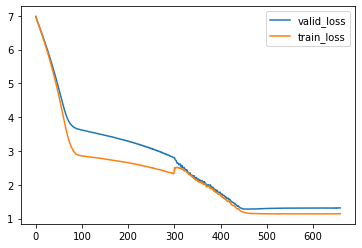

train_loss: 1.55651 | train_metric: -1.55651
valid_loss: 1.27812 | valid_metric: -1.27812
test_loss:  1.29150 | test_metric:  -1.29150


Train loss: 1.148 | Validation loss 1.332:  50%|█████     | 605/1200 [01:21<01:20,  7.42it/s]


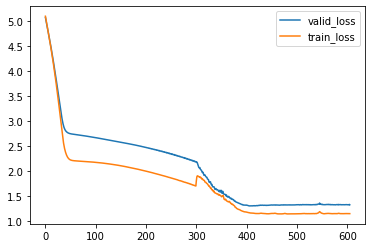

train_loss: 1.59163 | train_metric: -1.59163
valid_loss: 1.30174 | valid_metric: -1.30174
test_loss:  1.31771 | test_metric:  -1.31771


Train loss: 1.131 | Validation loss 1.331:  50%|████▉     | 595/1200 [00:55<00:56, 10.63it/s]


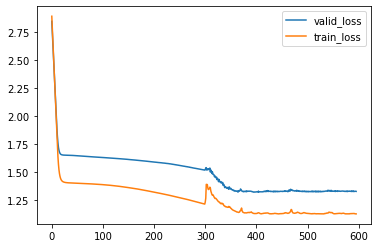

train_loss: 1.54080 | train_metric: -1.54080
valid_loss: 1.32281 | valid_metric: -1.32281
test_loss:  1.33075 | test_metric:  -1.33075
CPU times: user 4min 18s, sys: 4.49 s, total: 4min 23s
Wall time: 4min 24s


In [26]:
%%time
print("Use Jensen-Shannon divergence")
train_model(config, draw=True)
train_model({**config, 'EMBEDDING_DIM':25}, draw=True)
train_model({**config, 'EMBEDDING_DIM':5}, draw=True)

Use Kullback-Leibler divergence


Train loss: 1.123 | Validation loss 1.361:  50%|████▉     | 598/1200 [01:39<01:40,  5.98it/s]


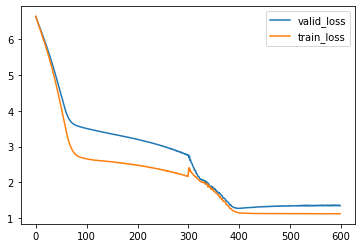

train_loss: 1.55506 | train_metric: -1.55506
valid_loss: 1.27552 | valid_metric: -1.27552
test_loss:  1.29172 | test_metric:  -1.29172


Train loss: 1.116 | Validation loss 1.360:  48%|████▊     | 579/1200 [01:04<01:09,  8.96it/s]


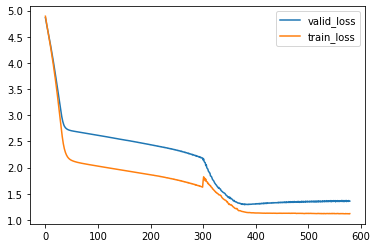

train_loss: 1.57889 | train_metric: -1.57889
valid_loss: 1.29141 | valid_metric: -1.29141
test_loss:  1.30735 | test_metric:  -1.30735


Train loss: 1.111 | Validation loss 1.356:  51%|█████     | 609/1200 [00:43<00:42, 14.05it/s]


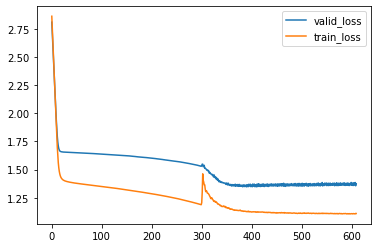

train_loss: 1.57976 | train_metric: -1.57976
valid_loss: 1.34670 | valid_metric: -1.34670
test_loss:  1.35372 | test_metric:  -1.35372
CPU times: user 3min 23s, sys: 4.2 s, total: 3min 27s
Wall time: 3min 29s


In [27]:
%%time
print("Use Kullback-Leibler divergence")
train_model({**config, 'DIST_METRIC':'KL'}, draw=True)
train_model({**config, 'DIST_METRIC':'KL','EMBEDDING_DIM':25}, draw=True)
train_model({**config, 'DIST_METRIC':'KL','EMBEDDING_DIM':5}, draw=True)